In [46]:
import os
#os.chdir('/Users/wangjiashun/Documents/GitHub/sbi') 
import pandas as pd

from torch import nn
from typing import Optional

import numpy as np
import matplotlib.pyplot as plt
import torch
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer

from sbi.neural_nets.mnle import MixedDensityEstimator, CategoricalNet
from pyknos.nflows import flows, transforms
from pyknos.nflows import distributions as distributions_


from sbi.inference import MNLE
from pyro.distributions import InverseGamma
from torch.distributions import Beta, Binomial, Gamma
from sbi.utils import MultipleIndependent

from sbi.inference import MCMCPosterior, VIPosterior, RejectionPosterior
from sbi.utils.torchutils import atleast_2d

from sbi.utils import mcmc_transform
from sbi.inference.potentials.base_potential import BasePotential

from pyddm import Model
from pyddm.models import DriftConstant, DriftLinear, NoiseConstant, BoundConstant, OverlayNonDecision, ICPointSourceCenter
from pyddm.functions import fit_adjust_model, display_model

from pyddm import Fittable, Fitted, Sample
from pyddm.models import LossRobustBIC, LossBIC, LossLikelihood, LossRobustLikelihood,LossSquaredError
from pyddm.functions import fit_adjust_model

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [16]:
def simulate_addm(d, theta, sigma, decision_threshold, time_step, max_time, fixation_pattern):
    """
    Simulate the aDDM (Attentional Drift Diffusion Model) with fixations.

    Parameters:
    - d: Positive constant controlling the speed of integration
    - theta: Attentional bias parameter (between 0 and 1)
    - sigma: Standard deviation of Gaussian noise
    - decision_threshold: Decision threshold for RDV
    - time_step: Time step for the simulation
    - max_time: Maximum time to run the simulation
    - fixation_pattern: List of fixations over time ('left', 'right', or 'none')

    Returns:
    - decision: The decision made ('left' or 'right')
    - decision_time: The time taken to make the decision
    - rdv_over_time: RDV values over time
    """
    rdv = 0
    decision = None
    decision_time = 0
    rdv_over_time = []

    for t, fixation in zip(np.arange(0, max_time, time_step), fixation_pattern):
        # Compute drift rate μ based on the fixation
        if fixation == 'left':
            mu_ = d * (1 - theta)
            mu = d * (-theta)

        elif fixation == 'right':
            mu = d * (-theta)
        else:
            mu = 0

        # Update RDV
        rdv += mu * time_step + scipy.stats.norm.rvs(scale=sigma) * np.sqrt(time_step)
        rdv_over_time.append(rdv)

        # Check for decision
        if rdv >= decision_threshold:
            decision = 'left'
            decision_time = t
            break
        elif rdv <= -decision_threshold:
            decision = 'right'
            decision_time = t
            break

    return decision, decision_time, rdv_over_time

In [17]:

# Parameters for the aDDM
d = 0.1  # Speed of integration
theta = 0.5  # Attentional bias
sigma = 1  # Standard deviation of noise
decision_threshold = 1.0  # Decision threshold for RDV
time_step = 0.01  # Time step
max_time = 5.0  # Max time

# Example fixation pattern (can be adapted based on specific conditions)
fixation_pattern = ['none'] * 100 + ['left'] * 150 + ['right'] * 250

# Simulate the aDDM
decision, decision_time, rdv_over_time = simulate_addm(d, theta, sigma, decision_threshold, time_step, max_time, fixation_pattern)


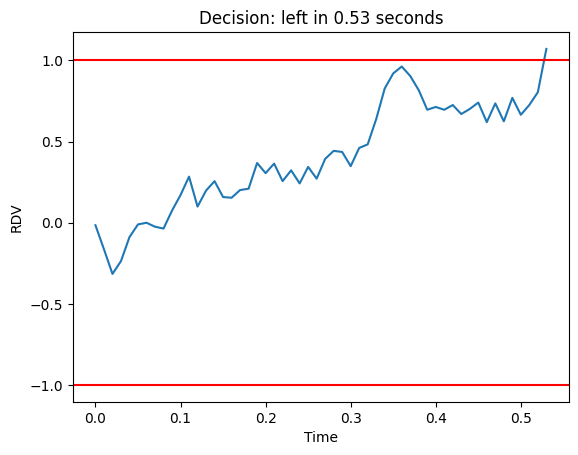

In [18]:

# Plot the results
plt.plot(np.arange(0, len(rdv_over_time) * time_step, time_step), rdv_over_time)
plt.axhline(y=decision_threshold, color='r', linestyle='-')
plt.axhline(y=-decision_threshold, color='r', linestyle='-')
plt.xlabel('Time')
plt.ylabel('RDV')
plt.title(f'Decision: {decision} in {decision_time:.2f} seconds')
plt.show()

In [43]:
def get_state_DDM(y,a):
    if y > a:
        state = 0  # 0 for option 1
    elif y < 0:
        state = 1  # 1 for option 2
    else:
        state = 2  # 2 for not finished
    return state

In [131]:
def simul_DDM(parameters, dt = 0.001, c = 0.01):
    n_sim = np.shape(parameters)[0]
    RTs, Rs = [], []
    attentions_matrix = np.zeros((n_sim,100))
    #print(n_sim)
    for i in range(n_sim):
        v = parameters[i,0]
        a = parameters[i,1]
        Ter = parameters[i,2]
        theta = parameters[i,3]
        
        init_loc = a*0.5
        
        n_iter = 1
        #location = init_loc
        y = init_loc
        attentions = []
        attention = np.random.randint(2)
        while(get_state_DDM(y,a)==2):
            dW = np.random.normal()*np.sqrt(dt)
            drift = v-theta*attention
            dy = drift*dt + c*dW
            y = y + dy
            n_iter = n_iter + 1
            if n_iter%100 ==0:
                attention = np.random.randint(2)
            if n_iter >=3000:
                break
            attentions.append(attention)
        attentions_matrix[i,:] = resample_att(attentions)

        RT = n_iter*dt + Ter
        R = get_state_DDM(y, a) # different from IDM
        RTs.append(RT)
        Rs.append(R)
        #print(RTs)

    RTs = torch.reshape(torch.Tensor(RTs), [n_sim,1])
    Rs = torch.reshape(torch.Tensor(Rs), [n_sim,1])
    return torch.cat((RTs,Rs),dim=1),attentions_matrix

In [132]:
#n_trials = 1000
sim_num = 10000

prior_DDM = utils.BoxUniform(low=[0,0.5,0,0.1], high=[4,2,1,0.1])
param_DDM = prior_DDM.sample((sim_num,))

data, attentions = simul_DDM(param_DDM)

One problem to plot the averaged attention is the scaling, because each trial has a different length. It is crucial to make each trial has the same length. One way to resample is to multiple the actual time points by the desired discret bins. For example, if we have 123 time points, we can multiple it with 100 to get 12300. Then we sample 0, 123, 246, 369... Finally, we will have the 100 bins.

In [92]:
def resample_att(attentions):
    period = len(attentions)
    upsampled = []
    for i in attentions:
        upsampled += [i]*100
    downsampled = [upsampled[i*period] for i in range(100)]
    return downsampled

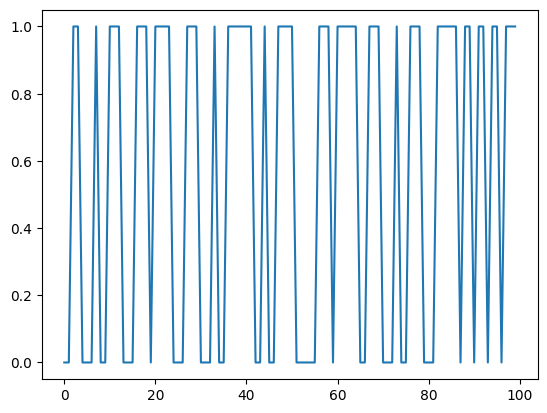

In [93]:
plt.plot(resample_att(attentions))

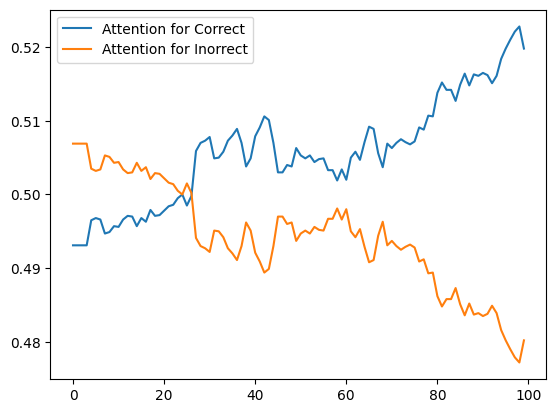

In [156]:
plt.plot(1-attentions.mean(axis = 0), label = "Attention for Correct")
plt.plot(attentions.mean(axis = 0), label = "Attention for Inorrect")
plt.legend()

In [141]:
attentions_averaged = list(attentions.mean(axis = 0).copy())

In [146]:
attentions_averaged_accu = [attentions_averaged[0]]
for i in range(1,100):
    attentions_averaged_accu.append(attentions_averaged[i]+attentions_averaged_accu[i-1])

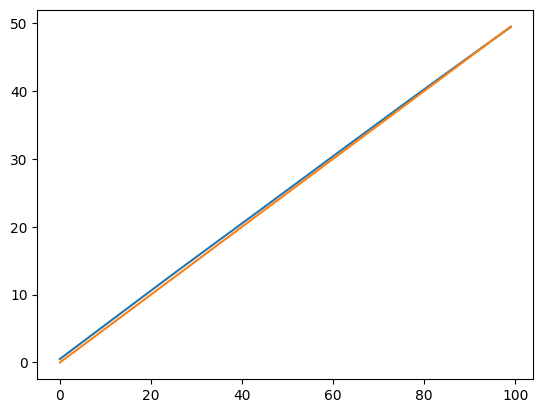

In [150]:
plt.plot(attentions_averaged_accu)
plt.plot(np.arange(100),np.arange(100)*0.5)

In [ ]:
a,b,c,d   sum = 100
e,f,g,h.  sum = 100

In [138]:
# one way
a, a+b, a+b+c...
e, e+f, e+f+g...

a+e/2, abef/2

SyntaxError: invalid syntax (4039066413.py, line 2)

In [ ]:
# the other way
a+e/2, b+f/2,

a+e/2, abef/2

In [164]:
data[:,1]

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [167]:
1-data[:,1]*2

tensor([1., 1., 1.,  ..., 1., 1., 1.])

In [ ]:
# if choice = 0, then nothing change
# if choice = 1, then swap 0 and 1 in attention
# -1*attention+1 can do the swap

In [168]:
1-attentions*2

array([[ 1.,  1.,  1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ...,  1.,  1.,  1.],
       ...,
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [ 1.,  1.,  1., ..., -1., -1.,  1.]])

In [170]:
(1-data[:,1]*2).reshape(10000,1)*(1-attentions*2)

tensor([[ 1.,  1.,  1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ...,  1.,  1.,  1.],
        ...,
        [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [ 1.,  1.,  1.,  ..., -1., -1.,  1.]], dtype=torch.float64)

In [177]:
attention_converted = ((1-data[:,1]*2).reshape(10000,1)*(1-attentions*2)+1)/2

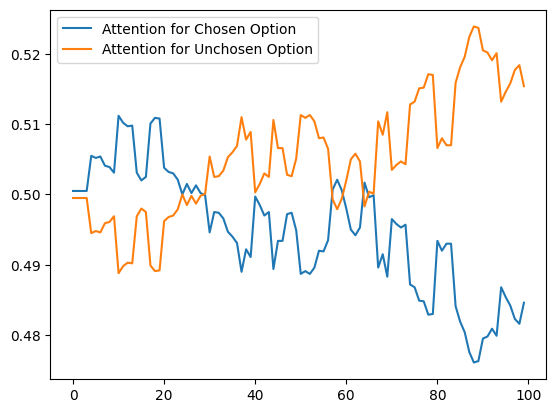

In [178]:
plt.plot(1-attention_converted.mean(axis = 0), label = "Attention for Chosen Option")
plt.plot(attention_converted.mean(axis = 0), label = "Attention for Unchosen Option")
plt.legend()

In [176]:
attention_converted

tensor([[ 1.,  1.,  1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ...,  1.,  1.,  1.],
        ...,
        [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [ 1.,  1.,  1.,  ..., -1., -1.,  1.]], dtype=torch.float64)